In [1]:
## Try to vectorize field boundaries from a raster image

%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('../scripts/')
import historic_wall_inference as hwi

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
if tuple([int(x) for x in matplotlib.__version__.split('.')]) < (3, 5, 0):
    print(f'MPL version {matplotlib.__version__} is too old to support plt.axline(), so do not use this function or update to 3.5.0 or higher')
import PIL
import skimage.transform

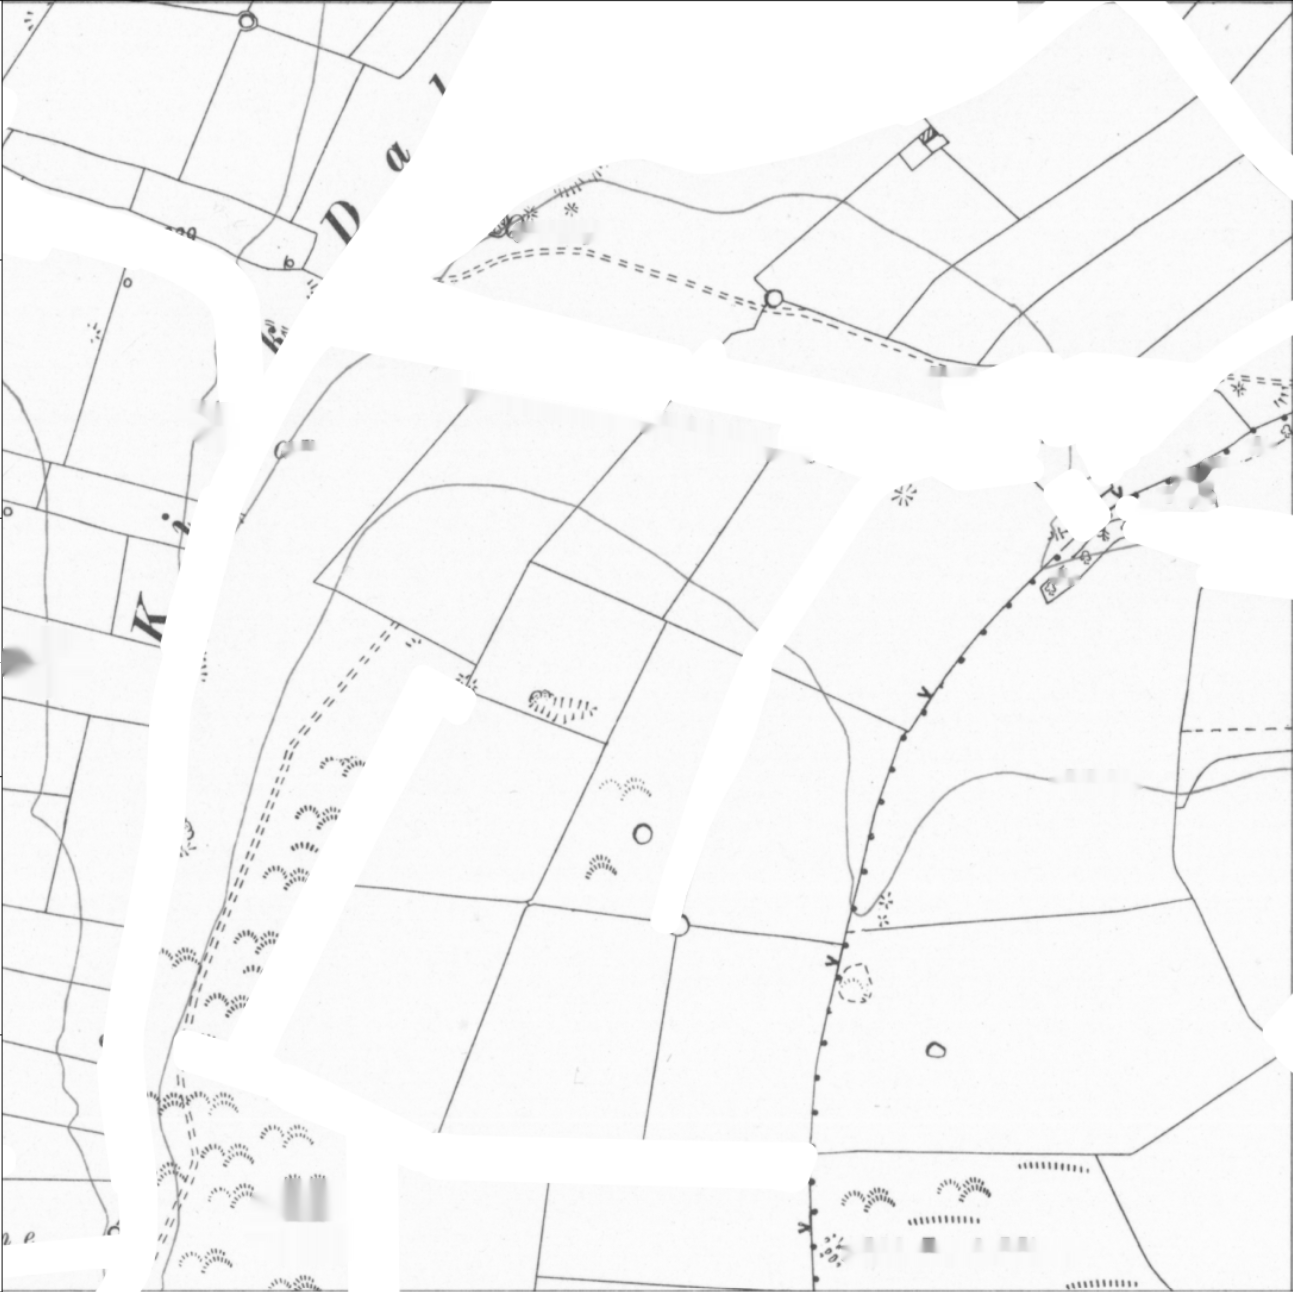

In [2]:
im = PIL.Image.open("../content/example_data/1k_example.tif")
im = im.convert("L")
im  # visualise in jupyter notebook:

C:\Users\alexad\AppData\Local\Temp\ipykernel_22488\825628913.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


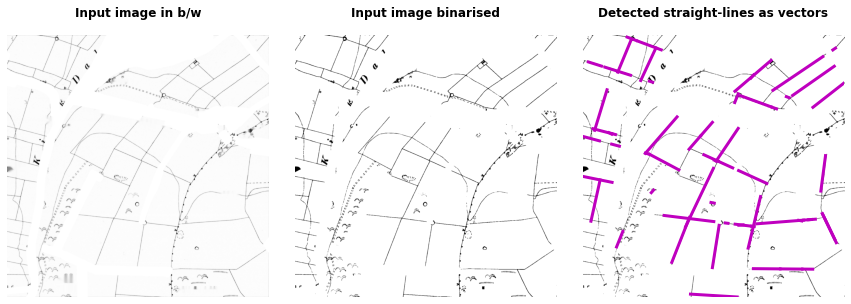

In [6]:
## Subselect part of image & convert to numpy array:
arr = np.array(im.getdata()).reshape(im.size[::-1])
#arr = arr[750:, :][:, :250]  # subselect (arbitrary) part of image because edge dectection works better on smaller images
arr = arr[3:-2 :][:, 3:-2]

## Binarise image:
arr_bin = hwi.binarise_array(arr)

## Hough transform to detect straight lines:
h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

## Find start and end points of each line:
list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(h=h, theta=theta, d=d, arr_bin=arr_bin)
          
## Plot results:
fig, ax = plt.subplots(1, 3, figsize=(15, 15), gridspec_kw={'wspace': 0.1})

## Original image:
ax[0].imshow(arr, cmap='Greys_r')
ax[0].set_title('Input image in b/w', fontdict={'weight': 'bold'}, y=1.05)
ax[0].set_axis_off()

## Binarised image:
ax[1].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[1].set_title('Input image binarised', fontdict={'weight': 'bold'}, y=1.05)
ax[1].set_axis_off()

## Binarised image, to be overlayed with detected lines
ax[2].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[2].set_ylim((arr_bin.shape[0], 0))
ax[2].set_xlim((0, arr_bin.shape[1]))
ax[2].set_axis_off()
ax[2].set_title('Detected straight-lines as vectors', fontdict={'weight': 'bold'}, y=1.05)
## Plot inferred lines:
for line in list_inferred_lines:
    ax[2].plot(line[0], line[1], c='m', linewidth=3)

plt.tight_layout()

In [7]:
df_inferred_lines

,x,y
0,"(401, 646)","(886.4772738783677, 916.5594912995792)"
1,"(702, 716)","(923.4354267101419, 925.1544105627826)"
2,"(751, 831)","(929.4518701943842, 939.2746350666166)"
3,"(832, 845)","(939.3974196275194, 940.9936189192572)"
4,"(597, 739)","(587.4666131129239, 652.179741398551)"
5,"(768, 907)","(665.395802808996, 728.7417523280251)"
6,"(507, 521)","(941.646484469456, 912.2948740822214)"
7,"(527, 644)","(899.7156124876924, 654.4200113943759)"
8,"(937, 1183)","(270.23654519956744, 104.30745005633048)"
9,"(1232, 1245)","(71.2565327310516, 62.48792201210006)"
